In [303]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats.stats import pearsonr
from scipy.stats import linregress

# All the functions

In [2]:
#define functions

#create function that finds mean of a function
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#create function that finds mean of a population
def weighted_total(a):
    weighted_total=0
    history_number=np.zeros((100,1)) #100 being the number of possible credit scores
    for i in range(100):
        number=sum(a==i) #number being the number of people having credit score i
        weighted_total+=number*i
        history_number[i]=number
    
    weighted_total/=sum(history_number)
    
    return weighted_total

#creates random distributions
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change



def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
    oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

    blues = true_blues.T
    oranges = true_oranges.T
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

# DO THINGS WITH BOTH

### DO THINGS WITHOUT FAIRNESS

In [ ]:
b_neutral, o_neutral, bwd_neutral, owd_neutral, mb, mo = create_blues_and_oranges()

In [ ]:
plt.hist([b_neutral, o_neutral], color=['b', 'xkcd:orange'])
plt.show()

In [ ]:
b_unfair = np.copy(b_neutral)
o_unfair = np.copy(o_neutral)
bwd_unfair = np.copy(bwd_neutral)
owd_unfair = np.copy(owd_neutral)

In [ ]:
number_of_iterations = 20
history_blue_unfair = np.zeros((number_of_iterations+1, 1000))
history_orange_unfair = np.zeros((number_of_iterations+1, 1000))
cutoff_history_unfair=np.zeros((number_of_iterations,2))
# b, o, bwd, owd, mb, mo = create_blues_and_oranges()
history_blue_unfair[0]=b_unfair
history_orange_unfair[0]=o_unfair


for i in range(number_of_iterations):


    #optimise cutoffs without fairness
    #what to optimise
    to_optimise = lambda x: total_bank_profit(b_unfair, o_unfair, bwd_unfair, 
                                              owd_unfair, x[0], x[1])

    to_constrain = lambda x: difference_bw_positive_rates(b_unfair, o_unfair, bwd_unfair, 
                                                          owd_unfair, x[0], x[1])

    #initial guess
    cutoffs = np.zeros(2)
    cutoffs[0] = 50
    cutoffs[1] = 50
    #show initial objective
    print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

    #optimise without fairness
    a = (0, 100)
    bounds = (a, a)

    solution_unfair = minimize(to_optimise, cutoffs, 
                        bounds=bounds
                               , options = {'eps': 3}
                              )

    x_unfair = solution_unfair.x

    loans_b = b_unfair < x_unfair[0]
    loans_o = o_unfair < x_unfair[1]
    
    
    
    true_positives_b = np.logical_and(np.logical_not(bwd_unfair), np.logical_not(loans_b))
    false_positives_b = np.logical_and(np.logical_not(loans_b), bwd_unfair)

    true_positives_o = np.logical_and(np.logical_not(owd_unfair), np.logical_not(loans_o))
    false_positives_o = np.logical_and(np.logical_not(loans_o), owd_unfair)


    b_unfair[true_positives_b] +=1
    b_unfair[false_positives_b] -=2
    b_unfair[b_unfair<1] = 1
    b_unfair[b_unfair>99] = 99

    o_unfair[true_positives_o] +=1
    o_unfair[false_positives_o] -=2
    o_unfair[o_unfair<1] = 1
    o_unfair[o_unfair>99] = 99

    b_unfair-=0.5
    o_unfair-=0.5

    history_blue_unfair[i+1]=b_unfair
    history_orange_unfair[i+1]=o_unfair
    cutoff_history_unfair[i]=x_unfair

    b_defaults = np.random.randint(100, size=(1000,))
    o_defaults = np.random.randint(100, size=(1000,))

    bwd_unfair = b_unfair < b_defaults
    owd_unfair = o_unfair < o_defaults


In [ ]:
for i in range(20):
    print(weighted_total(history_orange_unfair[i]), weighted_total(history_blue_unfair[i]))

In [ ]:
plt.hist([history_blue_unfair[0], history_orange_unfair[0]], color=['b', 'xkcd:orange'])
plt.show()

In [ ]:
plt.hist([history_blue_unfair[19], history_orange_unfair[19]], color=['b', 'xkcd:orange'])
plt.show()

### DO THINGS WITH FAIRNESS

In [13]:
b_fair = np.copy(b_neutral)
o_fair = np.copy(o_neutral)
bwd_fair = np.copy(bwd_neutral)
owd_fair = np.copy(owd_neutral)

In [14]:
number_of_iterations = 2
history_blue_fair = np.zeros((number_of_iterations+1, 1000))
history_orange_fair = np.zeros((number_of_iterations+1, 1000))
cutoff_history_fair=np.zeros((number_of_iterations,2))

history_blue_fair[0]=b_fair
history_orange_fair[0]=o_fair

In [5]:
credit_score_hist=np.zeros((200,1))

for q in range(200):
    for i in range(number_of_iterations):
        b_neutral, o_neutral, bwd_neutral, owd_neutral, mb, mo = create_blues_and_oranges()
        b_fair = np.copy(b_neutral)
        o_fair = np.copy(o_neutral)
        bwd_fair = np.copy(bwd_neutral)
        owd_fair = np.copy(owd_neutral)


        #optimise cutoffs without fairness
        #what to optimise
        to_optimise = lambda x: total_bank_profit(b_fair, o_fair, bwd_fair, 
                                                  owd_fair, x[0], x[1])

        #what to constrain
        to_constrain = lambda x: difference_bw_positive_rates(b_fair, o_fair, bwd_fair, 
                                                              owd_fair, x[0], x[1])

        #initial guess
        cutoffs = np.zeros(2)
        cutoffs[0] = 50
        cutoffs[1] = 50
        #show initial objective
    #     print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

        #optimise with fairness
        a = (0, 100)
        bounds = (a, a)

        #name constraints
        equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
        cons = ([equal_true_positives])



        solution_fair = minimize(to_optimise, cutoffs, 
                            bounds=bounds, constraints=cons
                                   , options = {'eps': 3, 'maxiter':10}
                                  )

        x_fair = solution_fair.x


        loans_b = b_fair > x_fair[0]
        true_positives_b = np.logical_and(loans_b, np.logical_not(bwd_fair))
        false_positives_b = np.logical_and(loans_b, bwd_fair)


        loans_o = o_fair > x_fair[1]
        true_positives_o = np.logical_and(loans_o, np.logical_not(owd_fair))
        false_positives_o = np.logical_and(loans_o, owd_fair)

        profit, _, credit_score_loss = bank_profit(b_fair, bwd_fair, x_fair[0])
        credit_score_hist[q]=credit_score_loss

        b_fair[true_positives_b] +=1
        b_fair[false_positives_b] -=2
        b_fair[b_fair<1] = 1
        b_fair[b_fair>99] = 99

        o_fair[true_positives_o] +=1
        o_fair[false_positives_o] -=2
        o_fair[o_fair<1] = 1
        o_fair[o_fair>99] = 99

        history_blue_fair[i+1]=b_fair
        history_orange_fair[i+1]=o_fair
        cutoff_history_fair[i]=x_fair

        b_defaults = np.random.randint(100, size=(1000,))
        o_defaults = np.random.randint(100, size=(1000,))

        bwd_fair = b_fair < b_defaults
        owd_fair = o_fair < o_defaults
    

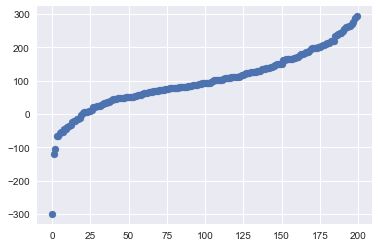

[20]


In [12]:
plt.scatter(np.arange(200),np.sort(credit_score_hist, axis=0))
plt.show()
print(sum(credit_score_hist < 0))

In [ ]:
for i in range(20):
    print(weighted_total(history_orange_fair[i]), weighted_total(history_blue_fair[i]))

In [ ]:
plt.hist([history_blue_fair[0], history_orange_fair[0]], color=['b', 'xkcd:orange'])
plt.show()

In [ ]:
plt.hist([history_blue_fair[19], history_orange_fair[19]], color=['b', 'xkcd:orange'])
plt.show()

In [ ]:
plt.hist([history_blue_unfair[19], history_orange_unfair[19]], color=['b', 'xkcd:orange'])
plt.show()

In [ ]:
print(sum(history_blue_unfair[0] < 50), sum(history_blue_fair[0] < 50))
print(sum(history_blue_unfair[20] < 50), sum(history_blue_fair[20] < 50))

In [54]:
how_many_iters_ugh = 10
how_much_history = 10

history_initials_blue = np.zeros((how_many_iters_ugh, 1000))
history_initials_orange = np.zeros((how_many_iters_ugh, 1000))

history_final_blue_fair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_final_orange_fair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_cutoff_fair = np.zeros((how_many_iters_ugh, how_much_history, 2))

history_final_blue_unfair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_final_orange_unfair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_cutoff_unfair = np.zeros((how_many_iters_ugh, how_much_history, 2))

In [55]:
i = np.nan
j=np.nan

In [56]:
for j in range(how_many_iters_ugh):
    
    print(j, "j")
    
    b_neutral, o_neutral, bwd_neutral, owd_neutral, mb, mo = create_blues_and_oranges()
    
    b_unfair = np.copy(b_neutral)
    o_unfair = np.copy(o_neutral)
    bwd_unfair = np.copy(bwd_neutral)
    owd_unfair = np.copy(owd_neutral)

    b_fair = np.copy(b_neutral)
    o_fair = np.copy(o_neutral)
    bwd_fair = np.copy(bwd_neutral)
    owd_fair = np.copy(owd_neutral)
    
    history_initials_blue[j] = b_neutral
    history_initials_orange[j] = o_neutral
    
    for i in range(how_much_history):


        print(i, "i1")
        #optimise cutoffs without fairness
        
        to_optimise = lambda x: total_bank_profit(b_unfair, o_unfair, bwd_unfair, 
                                                  owd_unfair, x[0], x[1])

        #initial guess
        cutoffs = np.zeros(2)
        cutoffs[0] = 50
        cutoffs[1] = 50


        #optimise without fairness
        a = (0, 100)
        bounds = (a, a)

        solution_unfair = minimize(to_optimise, cutoffs, 
                            bounds=bounds
                                   , options = {'eps': 3}
                                  )

        x_unfair = solution_unfair.x

        loans_b = b_unfair < x_unfair[0]
        loans_o = o_unfair < x_unfair[1]
        true_positives_b = np.logical_and(np.logical_not(bwd_unfair), np.logical_not(loans_b))
        false_positives_b = np.logical_and(np.logical_not(loans_b), bwd_unfair)

        true_positives_o = np.logical_and(np.logical_not(owd_unfair), np.logical_not(loans_o))
        false_positives_o = np.logical_and(np.logical_not(loans_o), owd_unfair)

        b_unfair[true_positives_b] +=5
        b_unfair[false_positives_b] -=10
        b_unfair[b_unfair<1] = 1
        b_unfair[b_unfair>99] = 99

        o_unfair[true_positives_o] +=5
        o_unfair[false_positives_o] -=10
        o_unfair[o_unfair<1] = 1
        o_unfair[o_unfair>99] = 99

        history_final_blue_unfair[j, i, :]=b_unfair
        history_final_orange_unfair[j, i, :]=o_unfair
        history_cutoff_unfair[i]=x_unfair

        bwd_unfair = b_unfair < np.random.randint(100, size=(1000,))
        owd_unfair = o_unfair < np.random.randint(100, size=(1000,))
    
    for i in range(how_much_history):
        
        print(i, "i2")


        #optimise cutoffs WITH fairness
        #what to optimise
        to_optimise = lambda x: total_bank_profit(b_fair, o_fair, bwd_fair, 
                                                  owd_fair, x[0], x[1])

        #what to constrain
        to_constrain = lambda x: difference_bw_positive_rates(b_fair, o_fair, bwd_fair, 
                                                              owd_fair, x[0], x[1])

        #initial guess
        cutoffs = np.zeros(2)
        cutoffs[0] = 50
        cutoffs[1] = 50

        a = (0, 100)
        bounds = (a, a)

        #name constraints
        equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
        cons = ([equal_true_positives])



        solution_fair = minimize(to_optimise, cutoffs, 
                            bounds=bounds, constraints=cons
                                   , options = {'eps': 3, 'maxiter':10}
                                  )

        x_fair = solution_fair.x


        loans_b = b_fair < x_fair[0]
        true_positives_b = np.logical_and(np.logical_not(loans_b), np.logical_not(bwd_fair))
        false_positives_b = np.logical_and(np.logical_not(loans_b), bwd_fair)


        loans_o = o_fair < x_fair[1]
        true_positives_o = np.logical_and(np.logical_not(loans_o), np.logical_not(owd_fair))
        false_positives_o = np.logical_and(np.logical_not(loans_o), owd_fair)

        b_fair[true_positives_b] +=5
        b_fair[false_positives_b] -=10
        b_fair[b_fair<1] = 1
        b_fair[b_fair>99] = 99

        o_fair[true_positives_o] +=5
        o_fair[false_positives_o] -=10
        o_fair[o_fair<1] = 1
        o_fair[o_fair>99] = 99

#         b_fair-=0.5
#         o_fair-=0.5

        history_final_blue_fair[j,i,:]=b_fair
        history_final_orange_fair[j,i,:]=o_fair
        history_cutoff_fair[j,i,:]=x_fair
        

        bwd_fair = b_fair < np.random.randint(100, size=(1000,))
        owd_fair = o_fair < np.random.randint(100, size=(1000,))
        


0 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
1 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
2 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
3 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
4 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
5 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
6 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
7 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
8 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2
2 i2
3 i2
4 i2
5 i2
6 i2
7 i2
8 i2
9 i2
9 j
0 i1
1 i1
2 i1
3 i1
4 i1
5 i1
6 i1
7 i1
8 i1
9 i1
0 i2
1 i2


Infrastructure to analyse stuff

In [ ]:
history_initials_blue
history_initials_orange

history_final_blue_fair
history_final_orange_fair
history_cutoff_fair

history_final_blue_unfair
history_final_orange_unfair
history_cutoff_unfair

In [53]:
weighted_total(history_final_blue_fair[0,2,:])

array([42.071])

In [117]:
fairs_blue = np.zeros((how_many_iters_ugh, how_much_history))
unfairs_blue = np.zeros((how_many_iters_ugh, how_much_history))
fairs_orange = np.zeros((how_many_iters_ugh, how_much_history))
unfairs_orange = np.zeros((how_many_iters_ugh, how_much_history))

In [118]:
for j in range(how_many_iters_ugh):    
    for i in range(how_much_history):
        
        fairs_blue[j,i] = weighted_total(history_final_blue_fair[j,i,:])
        unfairs_blue[j,i] =  weighted_total(history_final_blue_unfair[j,i,:])
        fairs_orange[j,i] = weighted_total(history_final_orange_fair[j,i,:])
        unfairs_orange[j,i] =  weighted_total(history_final_orange_unfair[j,i,:])

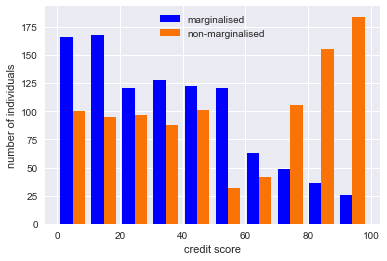

In [282]:
plt.hist([history_initials_blue[2,:], history_initials_orange[2,:]] ,color=['b', 'xkcd:orange'])
plt.legend(("marginalised", "non-marginalised"))
plt.ylabel("number of individuals")
plt.xlabel("credit score")
plt.show()

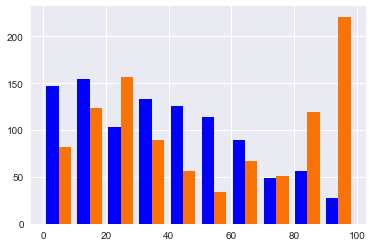

In [279]:
plt.hist([history_initials_blue[9,:], history_initials_orange[9,:]] ,color=['b', 'xkcd:orange'])
plt.show()

In [266]:
print(fairs_blue)

[[33.619 33.896 34.125 34.423 34.496 34.636 34.832 34.989 35.038 35.132]
 [32.071 32.168 32.245 32.565 32.732 32.811 32.785 32.843 32.927 32.999]
 [35.78  35.868 35.331 34.976 34.437 34.325 34.017 33.447 32.87  32.905]
 [53.614 54.37  54.866 55.168 55.51  55.786 55.838 55.941 55.958 56.161]
 [39.403 39.711 40.057 40.458 40.654 40.822 40.927 41.022 41.195 41.325]
 [42.943 43.502 43.778 43.927 44.146 44.137 44.156 44.297 44.103 44.094]
 [49.994 50.364 50.66  50.576 50.848 51.061 51.307 51.528 51.748 51.916]
 [33.926 34.045 34.058 34.263 34.191 34.305 34.453 34.585 34.67  34.792]
 [46.65  46.963 47.098 47.279 47.392 47.392 47.471 47.519 47.544 47.575]
 [38.573 38.27  38.06  38.179 37.939 37.702 36.866 36.686 35.879 35.654]]


In [241]:
colours = np.zeros((how_many_iters_ugh*how_much_history, 4))
colours[:,3] = 1
colours[:,0:2] = 200/255
colours[:,2] = 255/255
for i in range(how_much_history*how_much_history):
    colours[i,0:2]-= (i % how_much_history)*200/255/how_much_history

print(colours[10])

[0.78431373 0.78431373 1.         1.        ]


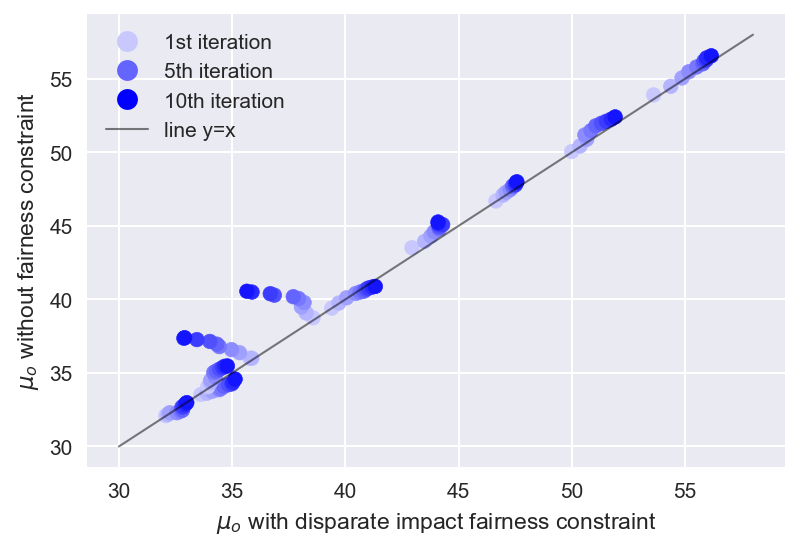

In [275]:
legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(200/255,200/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(100/255,100/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(0/255,0/255,255/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(fairs_blue, unfairs_blue, c=colours)
ax.plot(np.linspace(30,58), np.linspace(30,58), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu_o$ without fairness constraint")
ax.set_xlabel("$\mu_o$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_blues.png")
plt.show()

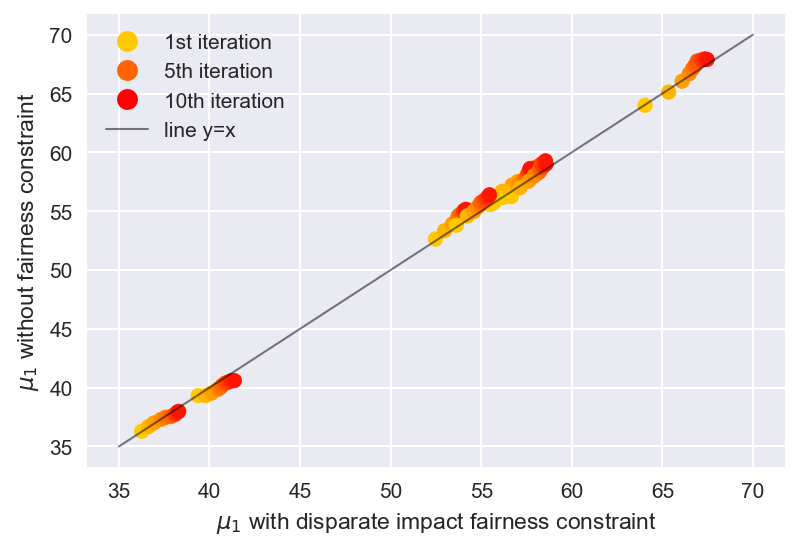

In [276]:
colours_orange = np.zeros((how_many_iters_ugh*how_much_history, 4))
colours_orange[:,3] = 1
colours_orange[:,0] = 255/255
colours_orange[:,1] = 200/255
colours_orange[:,2] = 0/255
for i in range(how_much_history*how_much_history):
    colours_orange[i,1]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(255/255,200/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(255/255,100/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(255/255,0/255,0/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(fairs_orange, unfairs_orange, c=colours_orange)
ax.plot(np.linspace(35,70), np.linspace(35,70), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu_1$ without fairness constraint")
ax.set_xlabel("$\mu_1$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_oranges.png")
plt.show()

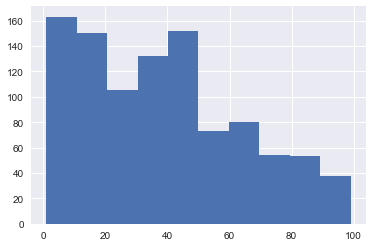

In [99]:
plt.hist(history_final_blue_fair[9,0,:])
plt.show()

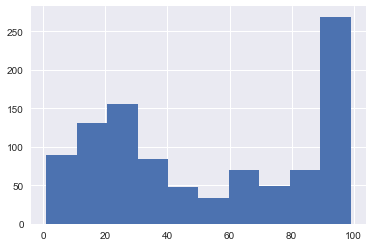

In [62]:
plt.hist(history_final_orange_fair[9,0,:])
plt.show()

In [297]:
t1 = np.copy(fairs_blue)
t2 = np.copy(unfairs_blue)

In [343]:
t = np.zeros((10,2))
t1 = (fairs_blue[:,-1] - fairs_blue[:,0])/10
t2 = (unfairs_blue[:,-1] - unfairs_blue[:,0])/10
t[:,0] = t1
t[:,1] = t2
print(t1)
print(t2)

[ 0.1513  0.0928 -0.2875  0.2547  0.1922  0.1151  0.1922  0.0866  0.0925
 -0.2919]
[0.1049 0.0886 0.1396 0.266  0.1475 0.1744 0.2354 0.1413 0.1301 0.1802]


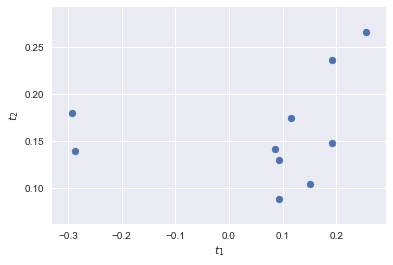

In [348]:
plt.scatter(t1, t2)
plt.xlabel("$t_1$")
plt.ylabel("$t_2$")
plt.show()

In [346]:
t[2,:] = 0
t[9,:] = 0

In [347]:
print(t)

[[0.1513 0.1049]
 [0.0928 0.0886]
 [0.     0.    ]
 [0.2547 0.266 ]
 [0.1922 0.1475]
 [0.1151 0.1744]
 [0.1922 0.2354]
 [0.0866 0.1413]
 [0.0925 0.1301]
 [0.     0.    ]]


In [349]:
pearsonr(t[:,0], t[:,1])

(0.9017952458760448, 0.0003609001299638952)

In [304]:
linregress(t1, t2)

LinregressResult(slope=0.06297822322916236, intercept=0.15703390225089606, rvalue=0.21879045965112373, pvalue=0.5436557741459115, stderr=0.09930367521718632)